# Face Expression classifier

## Creation of Image data generator

In [1]:
import cv2
# To check shape of the image
a = cv2.imread(
    r"D:\Condran\Data Science\Computer vision\Face detection project\fer2013\train\Angry\1.jpg"
)
a.shape

(48, 48, 3)

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dropout,Flatten,Dense,Conv2D,MaxPooling2D,ZeroPadding2D,BatchNormalization,ELU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.preprocessing.image import img_to_array

In [3]:
import_shape = (48, 48)
img_width = 48
img_height = 48
epoch = 25
batch_size = 16

# Train test directory
train_data_dir = r"D:\Condran\Data Science\Computer vision\Face detection project\fer2013\train"
test_data_dir = r"D:\Condran\Data Science\Computer vision\Face detection project\fer2013\validation"

# Validation set
validation_datagen = ImageDataGenerator(rescale=1. / 255)

validation_datagen = validation_datagen.flow_from_directory(
    test_data_dir,
    target_size=import_shape,
    color_mode='grayscale',  # since images are in greyscale
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=7)

# Training set with augmentation to avoid over fitting
train_datagen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   channel_shift_range=0.0,
                                   fill_mode='nearest',
                                   horizontal_flip=True,
                                   rescale=1. / 255)

train_datagen = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=import_shape,
    color_mode='grayscale',  # since images are in greyscale
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=7)

Found 3534 images belonging to 6 classes.
Found 28273 images belonging to 6 classes.


## little VGG

In [74]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal",
                 input_shape=(img_width, img_height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal",
                 input_shape=(img_width, img_height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #2: second CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #3: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #4: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #5: first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #6: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #7: softmax classifier
model.add(Dense(number_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
activation_10 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)       

In [78]:
# Setting checkpointing and earlystopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    "Face_emotion.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)

# We put our call backs into a callback list
callbacks = [earlystopping, checkpoint, reduce_lr]

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'])

In [80]:
nb_train_samples = 28273
nb_validation_samples = 3534

history = model.fit(train_datagen,
                    batch_size=batch_size,
                    epochs=40,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=validation_datagen,
                    steps_per_epoch=nb_train_samples // batch_size,
                    validation_steps=nb_validation_samples // batch_size)

Epoch 1/40
1767/1767 [==============================] - 540s 306ms/step - loss: 1.7155 - accuracy: 0.2661 - val_loss: 2.1012 - val_accuracy: 0.2071

Epoch 00001: val_loss did not improve from 1.71792
Epoch 2/40
1767/1767 [==============================] - 559s 317ms/step - loss: 1.6766 - accuracy: 0.2917 - val_loss: 1.7606 - val_accuracy: 0.3261

Epoch 00002: val_loss did not improve from 1.71792
Epoch 3/40
1767/1767 [==============================] - 534s 302ms/step - loss: 1.6116 - accuracy: 0.3356 - val_loss: 1.5915 - val_accuracy: 0.4082

Epoch 00003: val_loss improved from 1.71792 to 1.59145, saving model to Face_emotion.h5
Epoch 4/40
1767/1767 [==============================] - 533s 302ms/step - loss: 1.5367 - accuracy: 0.3799 - val_loss: 1.4847 - val_accuracy: 0.4207

Epoch 00004: val_loss improved from 1.59145 to 1.48474, saving model to Face_emotion.h5
Epoch 5/40
1767/1767 [==============================] - 527s 298ms/step - loss: 1.4808 - accuracy: 0.4093 - val_loss: 1.4933 -

In [82]:
model.save("Face_emotion_49%")

INFO:tensorflow:Assets written to: Face_emotion_49%\assets


In [83]:
model.evaluate(validation_datagen,
               batch_size=16,
               verbose=1,
               steps=nb_validation_samples // batch_size)

220/220 [==============================] - 24s 109ms/step - loss: 1.4143 - accuracy: 0.4810


[1.4143024682998657, 0.48096591234207153]

## Visualization

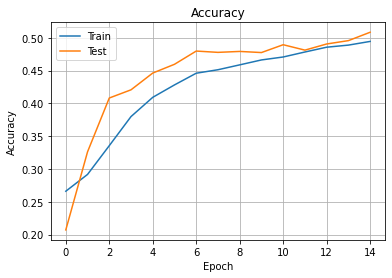

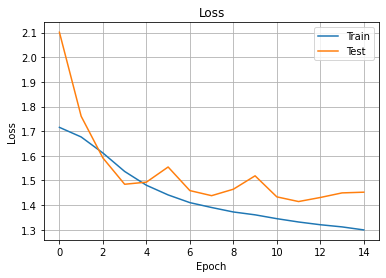

In [89]:
import matplotlib.pylab as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.grid()
plt.legend(["Train", "Test"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.grid()
plt.legend(["Train", "Test"])
plt.show()

## Confusion Matrix & Classification Report
* For better understanding of predicted results

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pylab as plt

In [8]:
# Note: turn off the shuffle or the the values wont be in the sequencefor predeicting purpose
validation_datagen = ImageDataGenerator(rescale=1. / 255)

validation_datagen = validation_datagen.flow_from_directory(
    test_data_dir,
    target_size=import_shape,
    color_mode='grayscale',  # since images are in greyscale
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    seed=7)

Found 3534 images belonging to 6 classes.


In [13]:
classifier = load_model("Face_emotion_49%/")
# this will give us the predicted probabilities for teh 6 classes
pred = classifier.predict(validation_datagen)

# argmax will pick the next number for the highest probability
clf = np.argmax(pred, axis=1)

# y_test classes
y_test = validation_datagen.classes

In [26]:
# Get the clases labels
class_labels = validation_datagen.class_indices

# Convert to dictionary interchnage v for k which will be beneficla for prediction
class_labels = {v: k for k, v in class_labels.items()}
classes = class_labels.values()

In [15]:
# Classification report
print(classification_report(y_test, clf, target_names=classes))

              precision    recall  f1-score   support

       Angry       0.45      0.36      0.40       491
        Fear       0.30      0.09      0.14       528
       Happy       0.74      0.85      0.79       879
     Neutral       0.23      0.31      0.26       626
         Sad       0.39      0.36      0.37       594
    Surprise       0.55      0.78      0.64       416

    accuracy                           0.48      3534
   macro avg       0.44      0.46      0.43      3534
weighted avg       0.46      0.48      0.46      3534



In [16]:
tick_marks = np.arange(len(classes))
tick_marks

array([0, 1, 2, 3, 4, 5])

{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}


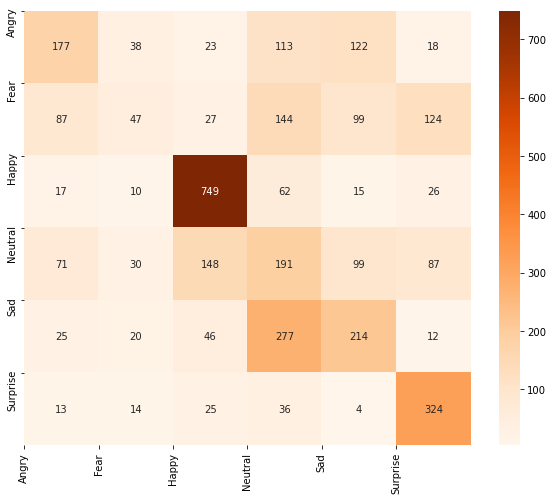

In [17]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, clf), annot=True, fmt='d', cmap='Oranges')
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
print(class_labels)

## Prediction

In [19]:
# loading the model
classifier = load_model("Face_emotion_49%/")

In [21]:
def draw_test(name, res, img_path, true_label):
    res = int(np.round(res))
    if res == 0:
        pred = "Angry"
    if res == 1:
        pred = "Fear"
    if res == 2:
        pred = "Happy"
    if res == 3:
        pred = "Neutral"
    if res == 4:
        pred = "Sad"
    if res == 5:
        pred = 'Surprise'

    # Convert the image to numbers
    input_im = cv2.imread(img_path)

    # Resize the iamge as per model requirement
    imageL = cv2.resize(input_im, (180, 180))
    expanded_image = cv2.copyMakeBorder(
        input_im, 0, 0, 0, input_im.shape[0] * 2, cv2.BORDER_CONSTANT, value=0)

    # Text for prediction
    cv2.putText(expanded_image, str(pred), (400, 180),
                cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (0, 255, 0), 2)

    cv2.imshow(name, expanded_image)


# Custom function to convert the raw image as per model requirment
def classify(img_path):
    # Convert the image to numbers
    input_im = cv2.imread(img_path, 0)

    # Resize the iamge as per model requirement
    imageL = cv2.resize(input_im, (48, 48))

    # Convert to fgloat and normalize the image
    input_im = imageL.astype("float") / 255.0
    # Convert to array format
    input_im = img_to_array(input_im)
    # Reshape the image as model.predict function (1,48,48,3)
    input_im = input_im.reshape(1, 48, 48, 1)
    # Get Prediction for probabilities
    res = classifier.predict_classes(x=input_im)

    # Using or custom fucntion draw test to display the image using OpenCV
    # Note the original image path is used here in the fucntion
    draw_test('Prediction', res, img_path, y_test)
    cv2.waitKey(0)


cv2.destroyAllWindows()

In [22]:
# Put in the path
img_path = "D:/Condran/IMG-20151214-WA0001.jpg"

# Use the classify function
classify(img_path)
cv2.destroyAllWindows()

C:\Users\Kevin\anaconda3\New folder\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## Face Detection

In [43]:
# Import Haarcascade Frontal face Detector
face_classifier = cv2.CascadeClassifier(
    'D:\Condran\Data Science\Computer vision\MasterOpenCV.tar\Master OpenCV\Haarcascades/haarcascade_frontalface_default.xml')


def face_detector(img):
    # Covert image to gray scale
    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    # Our classifier returns the ROI of the detected face as a tuple
    # It stores the top left coordinate and the bottom right coordiantes
    # min neigbours will tell if there are mutiple face dected in area it will show as one face
    # eg if the number is set to 5 it will show 5 dected face as 1
    # ScaleFactor- Smaller values, like 1.05 will take longer to compute, but will increase the rate of detection.
    faces = face_classifier.detectMultiScale(
        gray, scaleFactor=1.3, minNeighbors=5)
    if faces is ():
        return (0, 0, 0, 0), np.zeros((48, 48), np.uint8), img

    allfaces = []
    rects = []
    for (x, y, w, h) in faces:
        # creating a rectangle with border only
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        # cropping the image will be used for our predictor classifer
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)
        # to detect mutiple face if any
        allfaces.append(roi_gray)
        # saving the corodinates
        rects.append((x, w, y, h))
    return rects, allfaces, img


# Image link to be predicted
img = cv2.imread("D:\Condran\IMG-20151214-WA0001.jpg")
rects, faces, image = face_detector(img)


i = 0
for face in faces:
    # normalize the images
    roi = face.astype("float") / 255.0
    # convert to array
    roi = img_to_array(roi)
    # will chnage the shape to (1, 368, 304, 3) -. whichy is a requirement for model.predict
    roi = np.expand_dims(roi, axis=0)

    # make a prediction on the ROI, then lookup the class
    preds = classifier.predict(roi)[0]
    # class label is the dictionary with labels and numbers
    label = class_labels[preds.argmax()]

    # Overlay our detected emotion on our pic
    # label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    # i =+ 1
    cv2.putText(image, label, label_position,
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

cv2.imshow("Emotion Detector", image)
cv2.waitKey(0)

cv2.destroyAllWindows()

<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-43-e9e48efe3d14>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if faces is ():
